# `subgraph`의 입력과 출력을 변환하는 방법

`subgraph` **상태**가 `parent graph` 상태와 완전히 독립적일 수 있습니다. 

즉, 두 그래프 간에 중복되는 상태 키(state keys) 가 없을 수 있습니다. 

이러한 경우에는 `subgraph`를 호출하기 전에 입력을 변환하고, 반환하기 전에 출력을 변환해야 합니다. 

## 환경설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Modules")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Modules


## `graph`와 `subgraph` 정의

다음과 같이 3개의 `graph`를 정의하겠습니다.

- `parent graph`
  
- `parent graph` 에 의해 호출될 `child subgraph`

- `child graph` 에 의해 호출될 `grandchild subgraph`

## `grandchild` 정의

In [ ]:
# 상태 관리를 위한 TypedDict와 StateGraph 관련 모듈 임포트
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START, END


# 손자 노드의 상태를 정의하는 TypedDict 클래스, 문자열 타입의 my_grandchild_key 포함
class GrandChildState(TypedDict):
    my_grandchild_key: str


# 손자 노드의 상태를 처리하는 함수, 입력된 문자열에 인사말 추가
def grandchild_1(state: GrandChildState) -> GrandChildState:
    # 자식 또는 부모 키는 여기서 접근 불가
    return {"my_grandchild_key": f'([GrandChild] {state["my_grandchild_key"]})'}


# 손자 노드의 상태 그래프 초기화
grandchild = StateGraph(GrandChildState)

# 상태 그래프에 손자 노드 추가ㅁ
grandchild.add_node("grandchild_1", grandchild_1)

# 시작 노드에서 손자 노드로의 엣지 연결
grandchild.add_edge(START, "grandchild_1")

# 손자 노드에서 종료 노드로의 엣지 연결
grandchild.add_edge("grandchild_1", END)

# 정의된 상태 그래프 컴파일 및 실행 가능한 그래프 생성
grandchild_graph = grandchild.compile()

그래프를 시각화 합니다.

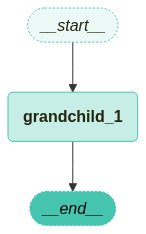

In [4]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(grandchild_graph, xray=True)

In [5]:
# 그래프 호출
for chunk in grandchild_graph.stream(
    {"my_grandchild_key": "Hi, Teddy!"}, subgraphs=True
):
    print(chunk)

((), {'grandchild_1': {'my_grandchild_key': '([GrandChild] Hi, Teddy!)'}})


## `child` 정의

In [6]:
# 자식 상태 타입 정의를 위한 TypedDict 클래스
class ChildState(TypedDict):
    my_child_key: str


# 손자 그래프 호출 및 상태 변환 함수, 자식 상태를 입력받아 변환된 자식 상태 반환
def call_grandchild_graph(state: ChildState) -> ChildState:
    # 참고: 부모 또는 손자 키는 여기서 접근 불가능
    # 자식 상태 채널에서 손자 상태 채널로 상태 변환
    grandchild_graph_input = {"my_grandchild_key": state["my_child_key"]}
    # 손자 상태 채널에서 자식 상태 채널로 상태 변환 후 결과 반환
    grandchild_graph_output = grandchild_graph.invoke(grandchild_graph_input)
    return {"my_child_key": f'([Child] {grandchild_graph_output["my_grandchild_key"]})'}


# 자식 상태 그래프 초기화
child = StateGraph(ChildState)
# 참고: 컴파일된 그래프 대신 함수 전달
# 자식 그래프에 노드 추가 및 시작-종료 엣지 연결
child.add_node("child_1", call_grandchild_graph)
child.add_edge(START, "child_1")
child.add_edge("child_1", END)
# 자식 그래프 컴파일
child_graph = child.compile()

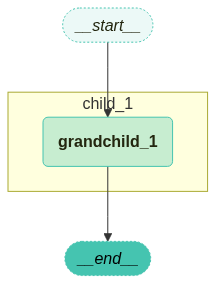

In [7]:
visualize_graph(child_graph, xray=True)

In [8]:
# child_graph 그래프 호출
for chunk in child_graph.stream({"my_child_key": "Hi, Teddy!"}, subgraphs=True):
    print(chunk)

(('child_1:2d72aae9-0ddc-a926-3127-0a5a4bcc6e5f',), {'grandchild_1': {'my_grandchild_key': '([GrandChild] Hi, Teddy!)'}})
((), {'child_1': {'my_child_key': '([Child] ([GrandChild] Hi, Teddy!))'}})


`grandchild_graph`의 호출을 별도의 함수(`call_grandchild_graph`)로 감싸고 있습니다. 

이 함수는 grandchild 그래프를 호출하기 전에 입력 상태를 변환하고, grandchild 그래프의 출력을 다시 child 그래프 상태로 변환합니다. 

만약 이러한 변환 없이 `grandchild_graph`를 직접 `.add_node`에 전달하면, child와 grandchild 상태 간에 공유된 상태 키(State Key) 이 없기 때문에 LangGraph에서 오류가 발생하게 됩니다.

**중요**

`child subgraph` 와 `grandchild subgraph`는 `parent graph`와 공유되지 않는 자신만의 **독립적인** `state`를 가지고 있다는 점에 유의하시기 바랍니다.

## `parent` 정의

In [9]:
# 부모 상태 타입 정의를 위한 TypedDict 클래스
class ParentState(TypedDict):
    my_parent_key: str


# 부모 상태의 my_parent_key 값에 '[Parent1]' 문자열을 추가하는 변환 함수
def parent_1(state: ParentState) -> ParentState:
    # 참고: 자식 또는 손자 키는 여기서 접근 불가
    return {"my_parent_key": f'([Parent1] {state["my_parent_key"]})'}


# 부모 상태의 my_parent_key 값에 '[Parent2]' 문자열을 추가하는 변환 함수
def parent_2(state: ParentState) -> ParentState:
    return {"my_parent_key": f'([Parent2] {state["my_parent_key"]})'}


# 부모 상태와 자식 상태 간의 데이터 변환 및 자식 그래프 호출 처리
def call_child_graph(state: ParentState) -> ParentState:
    # 부모 상태 채널(my_parent_key)에서 자식 상태 채널(my_child_key)로 상태 변환
    child_graph_input = {"my_child_key": state["my_parent_key"]}
    # 자식 상태 채널(my_child_key)에서 부모 상태 채널(my_parent_key)로 상태 변환
    child_graph_output = child_graph.invoke(child_graph_input)
    return {"my_parent_key": child_graph_output["my_child_key"]}


# 부모 상태 그래프 초기화 및 노드 구성
parent = StateGraph(ParentState)
parent.add_node("parent_1", parent_1)

# 참고: 컴파일된 그래프가 아닌 함수를 전달
parent.add_node("child", call_child_graph)
parent.add_node("parent_2", parent_2)

# 상태 그래프의 실행 흐름을 정의하는 엣지 구성
parent.add_edge(START, "parent_1")
parent.add_edge("parent_1", "child")
parent.add_edge("child", "parent_2")
parent.add_edge("parent_2", END)

# 구성된 부모 상태 그래프의 컴파일 및 실행 가능한 그래프 생성
parent_graph = parent.compile()

그래프를 시각화 합니다.

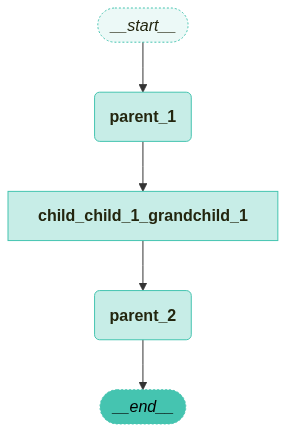

In [10]:
visualize_graph(parent_graph, xray=True)

`child_graph` 호출을 별도의 함수 `call_child_graph` 로 감싸고 있는데, 이 함수는 자식 그래프를 호출하기 전에 입력 상태를 변환하고 자식 그래프의 출력을 다시 부모 그래프 상태로 변환합니다. 

변환 없이 `child_graph`를 직접 `.add_node`에 전달하면 부모와 자식 상태 간에 공유된 상태 키(State Key) 이 없기 때문에 LangGraph에서 오류가 발생합니다.

그럼, 부모 그래프를 실행하여 자식 및 손자 하위 그래프가 올바르게 호출되는지 확인해보겠습니다.

In [11]:
# 그래프 실행 및 "my_parent_key" 매개변수를 통한 "Hi, Teddy!" 값 전달
for chunk in parent_graph.stream({"my_parent_key": "Hi, Teddy!"}, subgraphs=True):
    print(chunk)

((), {'parent_1': {'my_parent_key': '([Parent1] Hi, Teddy!)'}})
(('child:538b726a-513b-8a74-61f2-d10ffa761d31', 'child_1:e023aa2a-77e3-0965-9a74-a3a871abaada'), {'grandchild_1': {'my_grandchild_key': '([GrandChild] ([Parent1] Hi, Teddy!))'}})
(('child:538b726a-513b-8a74-61f2-d10ffa761d31',), {'child_1': {'my_child_key': '([Child] ([GrandChild] ([Parent1] Hi, Teddy!)))'}})
((), {'child': {'my_parent_key': '([Child] ([GrandChild] ([Parent1] Hi, Teddy!)))'}})
((), {'parent_2': {'my_parent_key': '([Parent2] ([Child] ([GrandChild] ([Parent1] Hi, Teddy!))))'}})
